## -------------------------------------------------------------------
## PROJETO FINAL: MODELO DE REGRESSÃO LINEAR
## GRUPO INFNET "R"
## Data: 08/09/2025
## Descrição: Análise dos fatores que influenciam os custos médicos.
## -------------------------------------------------------------------

### 1ª ETAPA: CONFIGURAÇÃO DO AMBIENTE

In [3]:
### Instalar pacotes
suppressMessages(install.packages("tidyverse"))
suppressMessages(install.packages("corrplot"))
suppressMessages(install.packages("ggplot2"))

pacote 'tidyverse' desempacotado com sucesso e somas MD5 verificadas

Os pacotes binários baixados estão em
	C:\Users\jfand\AppData\Local\Temp\Rtmp4COMyN\downloaded_packages
pacote 'corrplot' desempacotado com sucesso e somas MD5 verificadas

Os pacotes binários baixados estão em
	C:\Users\jfand\AppData\Local\Temp\Rtmp4COMyN\downloaded_packages
pacote 'S7' desempacotado com sucesso e somas MD5 verificadas
pacote 'ggplot2' desempacotado com sucesso e somas MD5 verificadas

Os pacotes binários baixados estão em
	C:\Users\jfand\AppData\Local\Temp\Rtmp4COMyN\downloaded_packages


In [4]:
### Carregar os pacotes
library(tidyverse)
library(corrplot)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
corrplot 0.95 loaded



### 2ª ETAPA: CARGA E VERIFICAÇÃO DOS DADOS

In [5]:
dados <- read.csv(".././data/insurance.csv")

In [6]:
# Verificar se os dados foram carregados corretamente
head(dados)
str(dados)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622


'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : chr  "female" "male" "male" "male" ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : chr  "yes" "no" "no" "no" ...
 $ region  : chr  "southwest" "southeast" "southeast" "northwest" ...
 $ charges : num  16885 1726 4449 21984 3867 ...


### 3ª ETAPA: LIMPEZA E PREPARAÇÃO

In [7]:
# Descreve a estrutura dos dados, e o primeiro ponto a se observar é a tipagem das colunas
# sex, smoker e region, que estão como chr, tornando impossível de se trabalhar com elas como
# colunas categóricas.

dados <- dados %>%
  mutate(
    sex = as.factor(sex),
    smoker = as.factor(smoker),
    region = as.factor(region)
  )

# Realiza-se então a conversão para o tipo factor e verifica-se a estrutura novamente.
str(dados)

'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 1 1 1 ...
 $ region  : Factor w/ 4 levels "northeast","northwest",..: 4 3 3 2 2 3 3 2 1 2 ...
 $ charges : num  16885 1726 4449 21984 3867 ...


In [8]:
colSums(is.na(dados))
# verificar valores faltantes (NA). O dataset está sem valores ausentes.

age      sex      bmi children   smoker   region  charges 
       0        0        0        0        0        0        0

In [9]:
duplicados <- sum(duplicated(dados))
print(paste("Número de linhas duplicadas encontradas:", duplicados))
# Identifica e exibe quantidade de linhas com valores duplicados.

[1] "Número de linhas duplicadas encontradas: 1"


In [10]:
if (duplicados > 0) {
  dados <- distinct(dados)
  print("Linha(s) duplicada(s) removida(s).")
}
#Verifica e remove valores duplicados.

[1] "Linha(s) duplicada(s) removida(s)."


## 4ª ETAPA: PRIMEIRA ANÁLISE

### ANÁLISE EXPLORATÓRIA

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


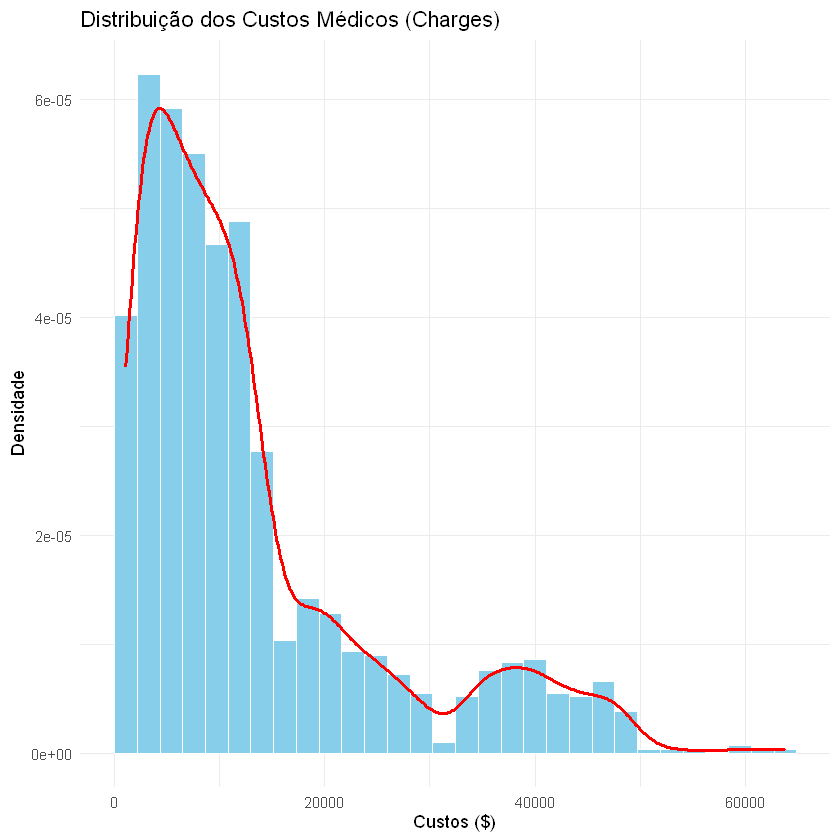

In [11]:
# a) Análise da Variável Dependente (Charges)
# Vamos criar um histograma para ver a distribuição dos custos.
ggplot(dados, aes(x = charges)) +
  geom_histogram(aes(y = ..density..), fill = "skyblue", color = "white", bins = 30) +
  geom_density(col = "red", size = 1) +
  labs(
    title = "Distribuição dos Custos Médicos (Charges)",
    x = "Custos ($)",
    y = "Densidade"
  ) +
  theme_minimal()


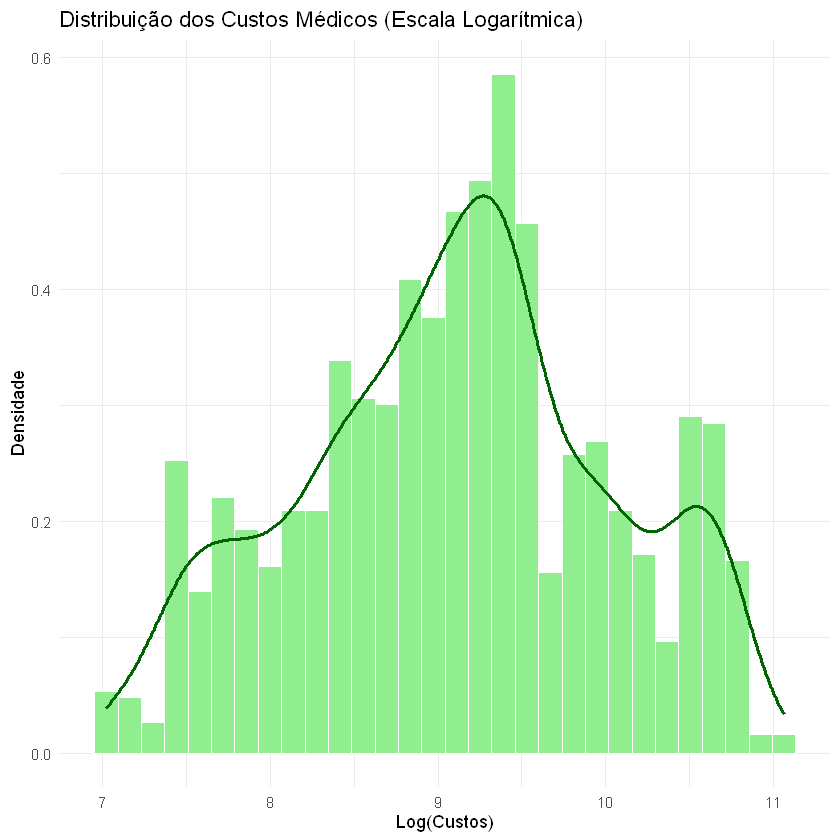

In [12]:
# b) Visualizando a transformação logarítmica
ggplot(dados, aes(x = log(charges))) +
  geom_histogram(aes(y = ..density..), fill = "lightgreen", color = "white", bins = 30) +
  geom_density(col = "darkgreen", size = 1) +
  labs(
    title = "Distribuição dos Custos Médicos (Escala Logarítmica)",
    x = "Log(Custos)",
    y = "Densidade"
  ) +
  theme_minimal()


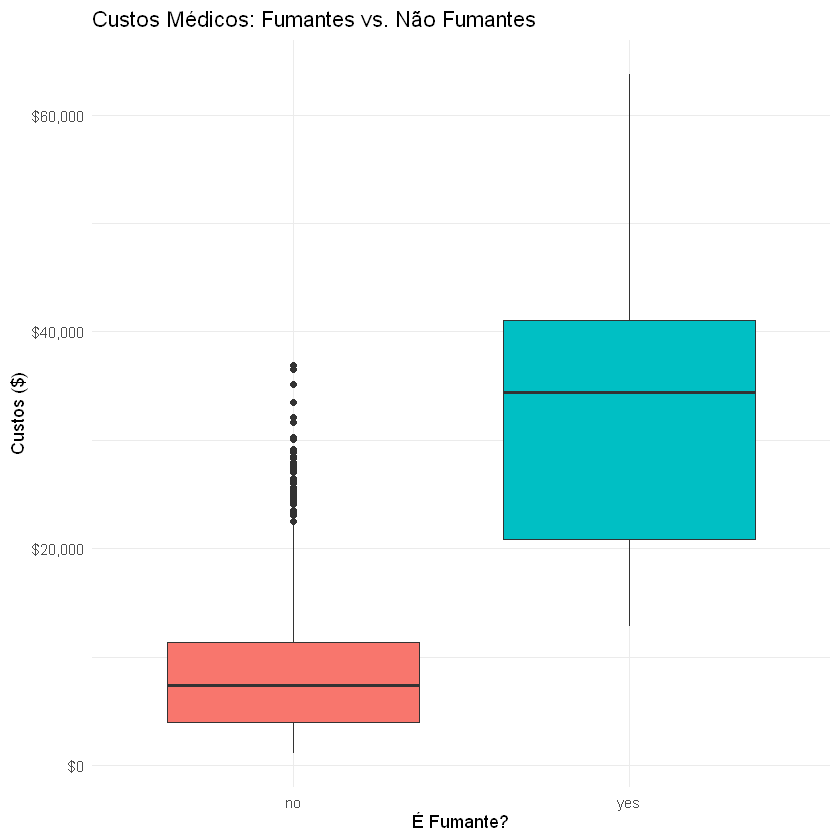

In [13]:
# c) Relação de Charges com Preditores Categóricos

# Charges vs. Smoker
ggplot(dados, aes(x = smoker, y = charges, fill = smoker)) +
  geom_boxplot(show.legend = FALSE) +
  labs(
    title = "Custos Médicos: Fumantes vs. Não Fumantes",
    x = "É Fumante?",
    y = "Custos ($)"
  ) +
  scale_y_continuous(labels = scales::dollar) + # Formata o eixo Y para dólar
  theme_minimal()


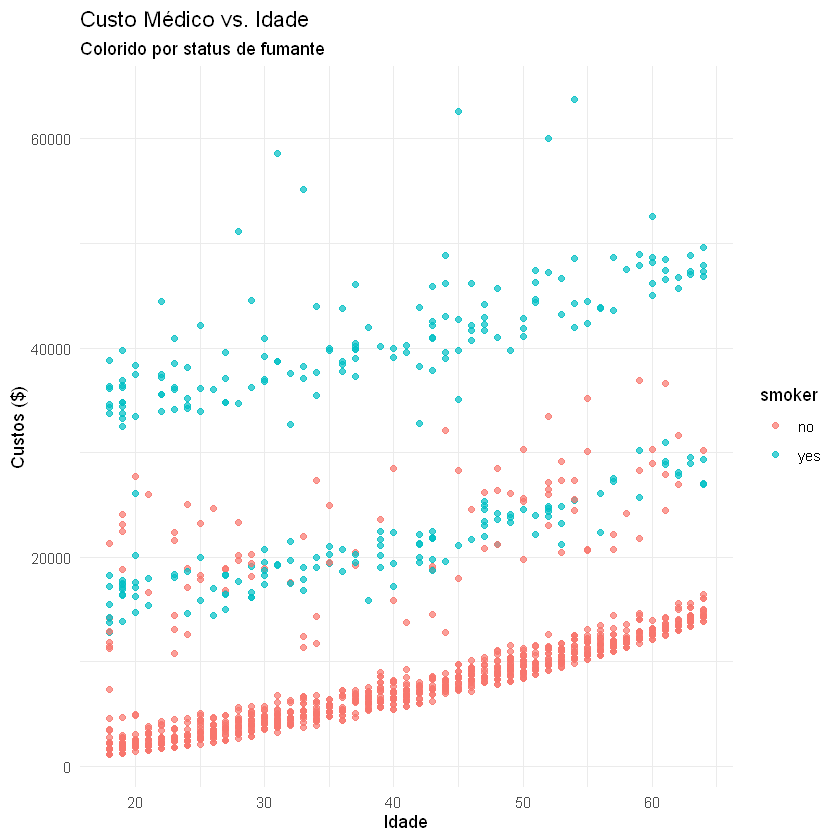

In [14]:
# d) Relação de Charges com Preditores Quantitativos

# Charges vs. Age (colorindo por smoker para mais insights)
ggplot(dados, aes(x = age, y = charges)) +
  geom_point(aes(color = smoker), alpha = 0.7) +
  labs(
    title = "Custo Médico vs. Idade",
    subtitle = "Colorido por status de fumante",
    x = "Idade",
    y = "Custos ($)"
  ) +
  theme_minimal()


### MODELAGEM - CONSTRUÇÃO DO MODELO

In [15]:
# Vamos construir nosso primeiro modelo usando os preditores que a Análise
# Exploratória sugeriu serem os mais importantes.
# Nossa variável dependente será log(charges) para satisfazer os pressupostos do modelo.

modelo_1 <- lm(log(charges) ~ age + bmi + smoker, data = dados)

In [16]:
# A função summary() nos dá um relatório completo sobre o nosso modelo.
# Este é o output mais importante de toda a sua análise!
summary(modelo_1)


Call:
lm(formula = log(charges) ~ age + bmi + smoker, data = dados)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22166 -0.21732 -0.03983  0.10344  2.07125 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.0761244  0.0715858   98.85  < 2e-16 ***
age         0.0350930  0.0009117   38.49  < 2e-16 ***
bmi         0.0107853  0.0020982    5.14 3.15e-07 ***
smokeryes   1.5451927  0.0315190   49.02  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.465 on 1333 degrees of freedom
Multiple R-squared:  0.7443,	Adjusted R-squared:  0.7438 
F-statistic:  1294 on 3 and 1333 DF,  p-value: < 2.2e-16


### DIAGNÓSTICO DO MODELO

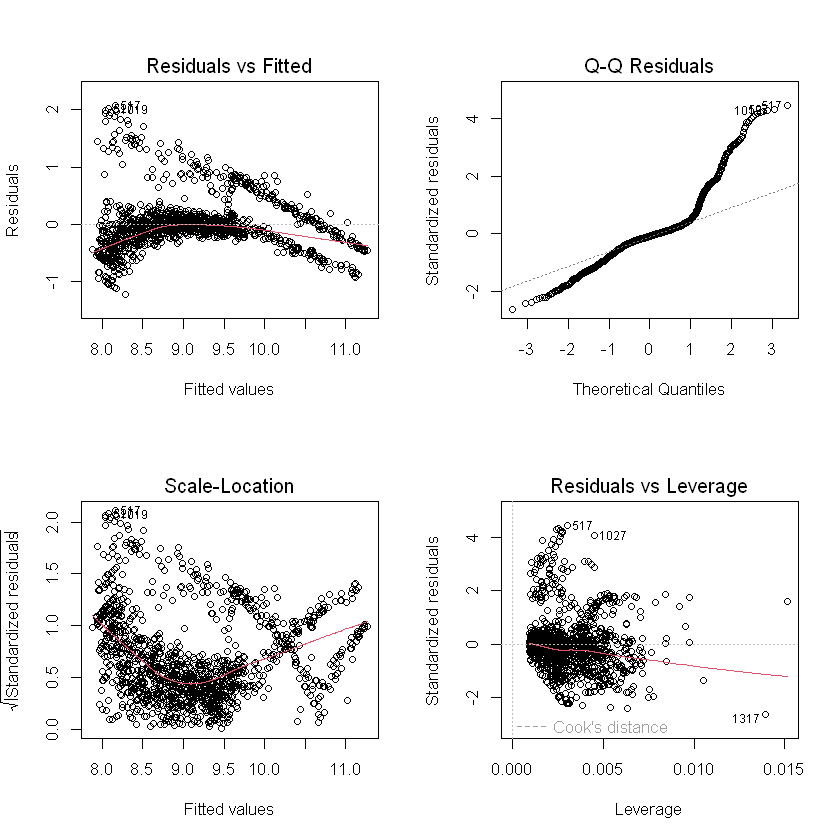

In [17]:
# A função plot() aplicada a um objeto 'lm' gera 4 gráficos de diagnóstico.
# Usamos par(mfrow = c(2, 2)) para arranjar os 4 gráficos em uma grade 2x2.

par(mfrow = c(2, 2))
plot(modelo_1)

# É uma boa prática resetar o layout gráfico para o padrão depois.
par(mfrow = c(1, 1))


## 5ª ETAPA: SEGUNDA ANÁLISE

### ANÁLISE EXPLORATÓRIA

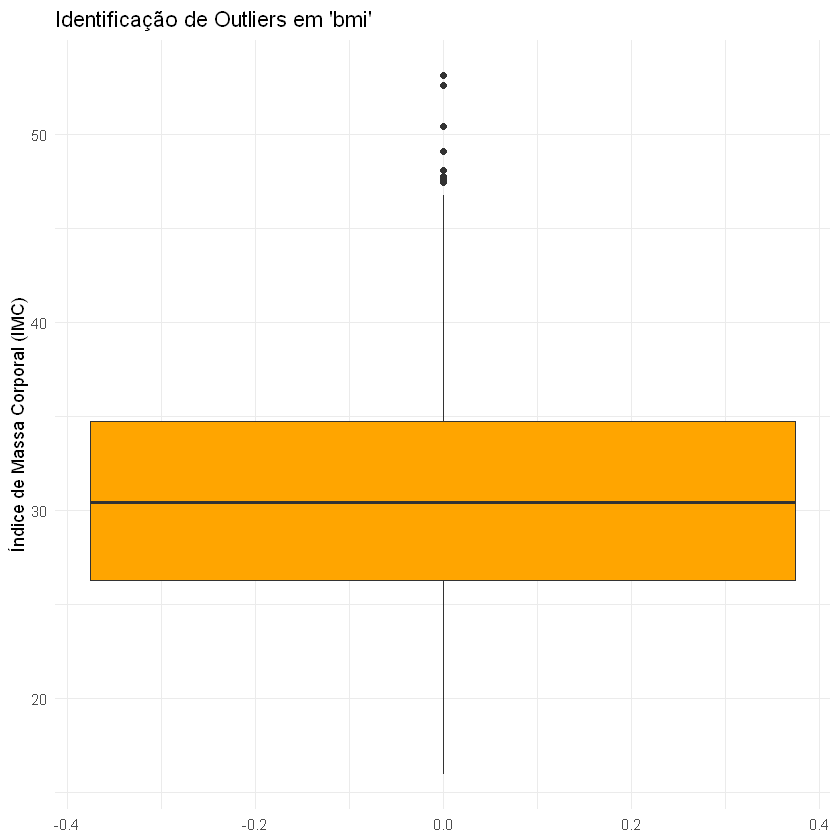

In [18]:
ggplot(dados, aes(y = bmi)) +
  geom_boxplot(fill = "orange") +
  labs(title = "Identificação de Outliers em 'bmi'", y = "Índice de Massa Corporal (IMC)") +
  theme_minimal()
# Visualizando um boxplot que distribui a mediana do IMC das pessoas, é possível identificar algumas discrepâncias com
# IMC muito alto, ou seja, outliers. Essas pessoas podem de fato possuir esse IMC, portanto, não serão desconsideradas.
# Isso pode apontar para o fato de que algumas pessoas podem ter custos médicos altos não em decorrência do cigarro, mas talvez
# da obesidade, podendo possuir esse fato correlação com o hábito de fumar ou não.

In [19]:
dados <- dados %>%
     rename(
       idade = age,
       sexo = sex,
       imc = bmi,
       filhos = children,
       fumante = smoker,
       regiao = region,
       custos = charges
     )
   head(dados)
# Renomeia colunas para melhor organização e identificação de seus dados.

,idade,sexo,imc,filhos,fumante,regiao,custos
,<int>,<fct>,<dbl>,<int>,<fct>,<fct>,<dbl>
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622


In [20]:
summary(dados)
# A Média de 'charges' ($13.2k) é bem maior que a Mediana ($9.3k),
# indicando que custos muito altos de poucas pessoas influenciam o total.
# A base é bem balanceada em sexo e região, mas com muito mais não-fumantes.


     idade           sexo          imc            filhos      fumante   
 Min.   :18.00   female:662   Min.   :15.96   Min.   :0.000   no :1063  
 1st Qu.:27.00   male  :675   1st Qu.:26.29   1st Qu.:0.000   yes: 274  
 Median :39.00                Median :30.40   Median :1.000             
 Mean   :39.22                Mean   :30.66   Mean   :1.096             
 3rd Qu.:51.00                3rd Qu.:34.70   3rd Qu.:2.000             
 Max.   :64.00                Max.   :53.13   Max.   :5.000             
       regiao        custos     
 northeast:324   Min.   : 1122  
 northwest:324   1st Qu.: 4746  
 southeast:364   Median : 9386  
 southwest:325   Mean   :13279  
                 3rd Qu.:16658  
                 Max.   :63770  

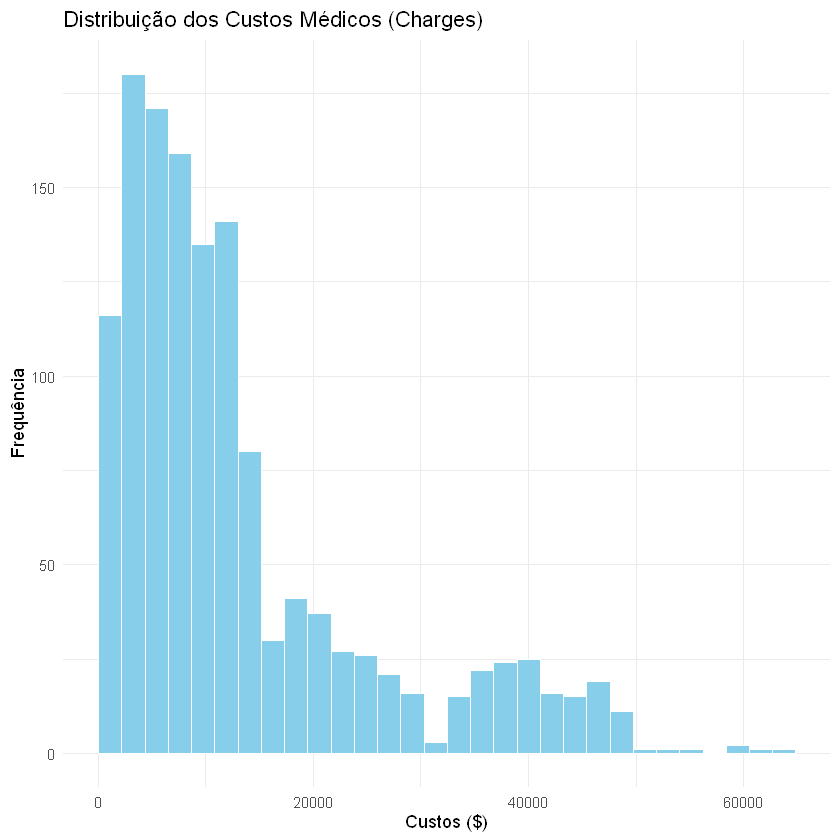

In [21]:
ggplot(dados, aes(x = custos)) +
  geom_histogram(fill = "skyblue", color = "white", bins = 30) +
  labs(
    title = "Distribuição dos Custos Médicos (Charges)",
    x = "Custos ($)",
    y = "Frequência"
  ) +
  theme_minimal()
# O gráfico exibe a distribuição horizontal dos custos médicos e o quão pertinentes eles são.
# É possível identificar uma assimetria a direita, indicando maior frequência de custos à esquerda.
# Ou seja, os gastos mais frequentes são os que estão à esquerda, os menores horizontalmente.
# Isso aponta para o fato de que as pessoas possuem mais custos médicos baixos do que altos.


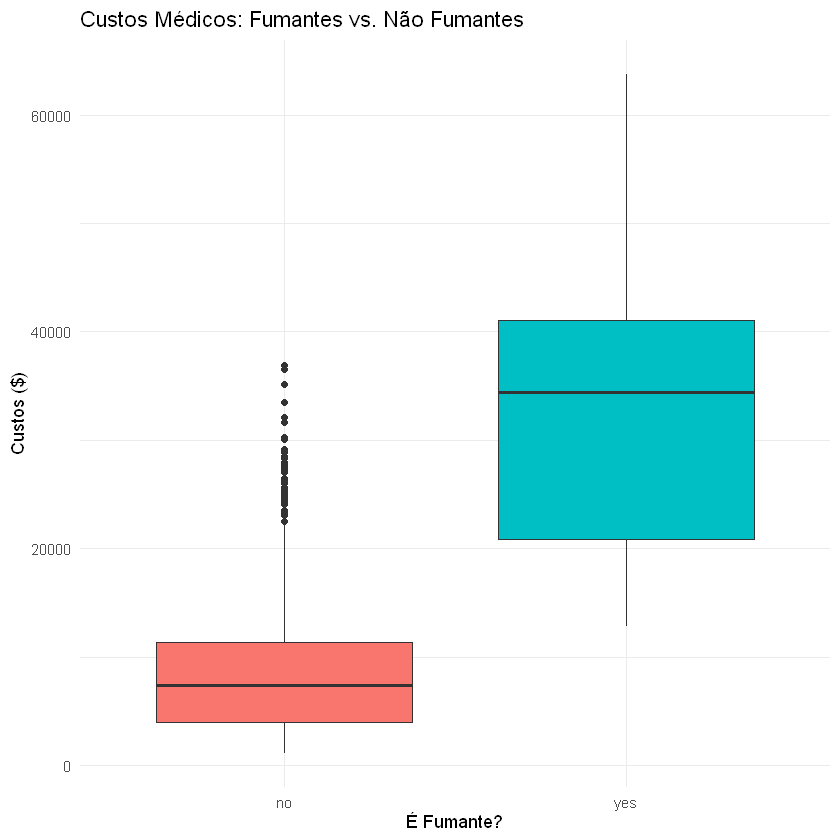

In [22]:
ggplot(dados, aes(x = fumante, y = custos, fill = fumante)) +
  geom_boxplot(show.legend = FALSE) +
  labs(
    title = "Custos Médicos: Fumantes vs. Não Fumantes",
    x = "É Fumante?",
    y = "Custos ($)"
  ) +
  theme_minimal()
# Dada as conclusões do gráfico anterior, deve-se analisar o ponto central da distribuição horizontal verificada,
# Uma vez que ela é assimétrica e demostra haverem alguns outliers
# É questionável também o fato de não sabermos quem são os fumantes e não-fumantes nessa distribuição.
# A partir da mediana dos custos médicos entre fumantes e não fumantes, algo fica claro.
# Pessoas que fumam possuem gastos muito maiores do que pessoas que não fumam, com exceção de alguns outliers.
# Isso leva a entender que os fumantes se encaixam na parte assimétrica do gráfico anterior.